In [1]:
%load_ext rpy2.ipython
import rpy2.robjects.lib.ggplot2 as ggplot2
import childespy
import numpy as np
import os
import imp
import pandas as pd
import transformers
import torch
import re
import unicodedata
import scipy.stats
import copy
from string import punctuation

import copy

In [2]:
import configuration
config = configuration.Config()

In [3]:
from utils_model_sampling import sample_models_across_time
from utils import load_models

In [4]:
# 7/2/21: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2
# end cite

In [5]:
config.scores_dir

'experiments/run_n500/scores/n=500/val'

## Note: running on unigram scores that may not be fully correct -- will correct when OM is back up.

In [6]:

raw_scores_across_time = pd.concat(sample_models_across_time.assemble_scores_no_order())

# Remove 0.5 and 4.0 because they are sparse.
raw_scores_across_time = raw_scores_across_time[~raw_scores_across_time.age.isin({0.5, 4.0})]


In [7]:
raw_scores_across_time.columns

Index(['rank', 'prob', 'entropy', 'num_tokens_in_context', 'bert_token_id',
       'set', 'mask_position', 'token', 'utterance_id', 'posterior_entropy',
       'prior_entropy', 'position_in_mask', 'kl_flat_to_prior',
       'kl_flat_to_posterior', 'posterior_probability', 'prior_probability',
       'edit_distance', 'highest_posterior_words', 'highest_prior_words',
       'highest_posterior_probabilities', 'highest_prior_probabilities',
       'sample_index', 'model', 'age', 'word', 'keep', 'Unnamed: 0', 'count'],
      dtype='object')

In [8]:
# Possibly too complex to generate the betas in the title automatically
# -- for now, just display the betas in the notebook separately.

from utils_model_sampling import beta_utils
from pprint import pprint

all_args = load_models.gen_all_model_args()

beta_set = {}
for arg_set in all_args:
    model_title = load_models.gen_model_title(*arg_set)
    this_beta = beta_utils.get_optimal_beta_value(*arg_set)
    
    beta_set[model_title] = round(this_beta, 3)
    
pprint(beta_set)

{'Adult BERT without tags, , +-20 utts context': 3.3,
 'Adult BERT without tags, , same utt only': 3.4,
 'CHILDES BERT with tags, , +-20 utts context': 3.0,
 'CHILDES BERT with tags, , same utt only': 3.1,
 'CHILDES BERT with tags, older children, +-20 utts context': 3.2,
 'CHILDES BERT with tags, older children, same utt only': 3.4,
 'CHILDES BERT with tags, younger children, +-20 utts context': 2.9,
 'CHILDES BERT with tags, younger children, same utt only': 3.0,
 'CHILDES BERT without tags, , +-20 utts context': 3.1,
 'CHILDES BERT without tags, , same utt only': 3.2,
 'CHILDES BERT without tags, older children, +-20 utts context': 3.3,
 'CHILDES BERT without tags, older children, same utt only': 3.4,
 'CHILDES BERT without tags, younger children, +-20 utts context': 2.9,
 'CHILDES BERT without tags, younger children, same utt only': 3.1,
 'CHILDES unigram without tags, , same utt only': 3.3,
 'Flat prior without tags, , same utt only': 3.4}


In [9]:
# From the original analysis

original_set_of_models = {
    'CHILDES BERT without tags, , +-20 utts context',
    'CHILDES BERT without tags, , same utt only',
    'Adult BERT without tags, , +-20 utts context',
    'Adult BERT without tags, , same utt only',
    'CHILDES Unigram',
    'Flat Unigram', 
}


tags_context_only = {
    "CHILDES BERT with tags, , +-20 utts context",
    'CHILDES BERT with tags, older children, +-20 utts context',
    'CHILDES BERT with tags, younger children, +-20 utts context',
    'CHILDES BERT without tags, , +-20 utts context',
    'CHILDES BERT without tags, older children, +-20 utts context',
    'CHILDES BERT without tags, younger children, +-20 utts context',
    'Flat Unigram',
}

merge_orig_tags = copy.deepcopy(tags_context_only)
merge_orig_tags.update(original_set_of_models)

scores_across_time = raw_scores_across_time.copy()


In [10]:
scores_across_time['token'] = scores_across_time['token'].astype(str)
scores_across_time_short = scores_across_time[['posterior_probability','posterior_entropy','prior_probability',
    'kl_flat_to_prior', 'kl_flat_to_posterior', 'model','set','age','token','bert_token_id', 'edit_distance']]
%R -i scores_across_time_short

In [11]:
%%R
library('plyr')
# rename the models

# Do this manually for now.

model_levels = c("CHILDES BERT with tags, , +-20 utts context",
                 'CHILDES BERT without tags, , +-20 utts context',
                 "CHILDES BERT with tags, , same utt only",
                 "CHILDES BERT without tags, , same utt only",
                 "Adult BERT without tags, , +-20 utts context",
                 "Adult BERT without tags, , same utt only",
                 "CHILDES BERT with tags, older children, +-20 utts context",
                 "CHILDES BERT without tags, older children, +-20 utts context",
                 "CHILDES BERT without tags, older children, same utt only",
                 "CHILDES BERT with tags, older children, same utt only",
                 "CHILDES BERT with tags, younger children, +-20 utts context",
                 "CHILDES BERT without tags, younger children, +-20 utts context",
                 "CHILDES BERT with tags, younger children, same utt only",
                 "CHILDES BERT without tags, younger children, same utt only",
                 "CHILDES Unigram",
                 "Flat Unigram"
)

model_new_levels = c("CHILDES BERT with tags, , +-20 utts context" = "CDL+Context+Tags",
                    "CHILDES BERT without tags, , +-20 utts context" = "CDL+Context",
                    "CHILDES BERT with tags, , same utt only" = "CDL+OneUtt+Tags",
                    "CHILDES BERT without tags, , same utt only" = "CDL+OneUtt", 
                    "Adult BERT without tags, , +-20 utts context" = "BERT+Context",
                    "Adult BERT without tags, , same utt only" = "BERT+OneUtt",
                    "CHILDES BERT with tags, older children, +-20 utts context" = "CDL+Older+Context+Tags",
                    "CHILDES BERT without tags, older children, +-20 utts context" = "CDL+Older+Context",
                    "CHILDES BERT with tags, older children, same utt only" = "CDL+Older+OneUtt+Tags",
                    "CHILDES BERT without tags, older children, same utt only" = "CDL+Older+OneUtt",
                    "CHILDES BERT with tags, younger children, +-20 utts context" = "CDL+Younger+Context+Tags",
                    "CHILDES BERT without tags, younger children, +-20 utts context" = "CDL+Younger+Context",
                    "CHILDES BERT with tags, younger children, same utt only" = "CDL+Younger+OneUtt+Tags", 
                    "CHILDES BERT without tags, younger children, same utt only" = "CDL+Younger+OneUtt",
                    "CHILDES Unigram" = "CHILDES 1gram",
                    "Flat Unigram" = "UniformPrior"
)


scores_across_time_short$model = factor(scores_across_time_short$model, model_levels)
scores_across_time_short$model = revalue(scores_across_time_short$model, model_new_levels)

successes_across_time = subset(scores_across_time_short, set == 'success')


In [12]:
set(scores_across_time['model']) #.columns # Flat is not available. You can add the flat score via? a manual run.
# But it will mix?

{'Adult BERT without tags, , +-20 utts context',
 'Adult BERT without tags, , same utt only',
 'CHILDES BERT with tags, , +-20 utts context',
 'CHILDES BERT with tags, , same utt only',
 'CHILDES BERT with tags, older children, +-20 utts context',
 'CHILDES BERT with tags, older children, same utt only',
 'CHILDES BERT with tags, younger children, +-20 utts context',
 'CHILDES BERT with tags, younger children, same utt only',
 'CHILDES BERT without tags, , +-20 utts context',
 'CHILDES BERT without tags, , same utt only',
 'CHILDES BERT without tags, older children, +-20 utts context',
 'CHILDES BERT without tags, older children, same utt only',
 'CHILDES BERT without tags, younger children, +-20 utts context',
 'CHILDES BERT without tags, younger children, same utt only',
 'CHILDES Unigram',
 'Flat Unigram'}

In [13]:
%%R 
get_ref_df = function(model, single_df){
    rdf = single_df
    single_df$line_model = single_df$model
    single_df$model = model
    return(single_df) 
}

# 10 Average Prior Surprisal

In [14]:
%%R
names(successes_across_time)

aggregate(prior_probability ~ model, successes_across_time, function(x){mean(-1 * log(x, base = 2))})

                      model prior_probability
1          CDL+Context+Tags          3.321474
2               CDL+Context          3.387521
3           CDL+OneUtt+Tags          5.056101
4                CDL+OneUtt          5.214744
5              BERT+Context          4.754680
6               BERT+OneUtt          7.398580
7    CDL+Older+Context+Tags          3.324933
8         CDL+Older+Context          3.433635
9          CDL+Older+OneUtt          5.242862
10    CDL+Older+OneUtt+Tags          5.063133
11 CDL+Younger+Context+Tags          3.507930
12      CDL+Younger+Context          3.549932
13  CDL+Younger+OneUtt+Tags          5.337346
14       CDL+Younger+OneUtt          5.462642
15            CHILDES 1gram          8.928521
16             UniformPrior         12.948367


In [15]:
%%R

# 7/15/21 not a code reference, but debugging help:
# https://stackoverflow.com/questions/60083062/tidyrspread-error-each-row-of-output-must-be-identified-by-a-unique-combina
# https://community.rstudio.com/t/spread-error-each-row-of-output-must-be-identified-by-a-unique-combination-of-keys/88325
# https://garrettgman.github.io/tidying

library('tidyr')
successes_across_time_wide =  spread(successes_across_time[,c('model','prior_probability',
'bert_token_id')], model, prior_probability)

head(successes_across_time_wide)

  bert_token_id CDL+Context+Tags CDL+Context CDL+OneUtt+Tags  CDL+OneUtt
1         42778      0.369946420 0.146721318     0.369946420 0.146721318
2         42779      0.008714092 0.017964307     0.008714092 0.017964307
3         43159      0.004863209 0.003964752     0.004863209 0.003964752
4         55768      0.937985837 0.947771907     0.584717512 0.346129179
5         55769      0.959741950 0.794826329     0.142853111 0.063012786
6         57441      0.090693690 0.221700907     0.076262102 0.059879798
  BERT+Context  BERT+OneUtt CDL+Older+Context+Tags CDL+Older+Context
1 0.1409282386 0.1409282386            0.304198146       0.224068031
2 0.0012918828 0.0012918828            0.007476315       0.006578689
3 0.0001744896 0.0001744896            0.004782162       0.003581698
4 0.1590228677 0.0013645076            0.906297565       0.935664117
5 0.0598898456 0.0001371365            0.923402071       0.751058459
6 0.4568772614 0.0188612249            0.232675448       0.302071780
  CDL+

In [16]:
%%R
#Pairwise paired t-test between all of the models

model_names = unique(successes_across_time$model) 

rvs = mat.or.vec(length(model_names), length(model_names))

for (model_idx in c(1:length(model_names))){
    for (comparison_model_idx in c(1:length(model_names))){
        if (model_idx == comparison_model_idx){
            rvs[model_idx, comparison_model_idx] = NA
        } else {
            model_name = model_names[model_idx]
            comparison_model_name = model_names[comparison_model_idx]
            rvs[model_idx, comparison_model_idx] = t.test(
                successes_across_time_wide[[model_name]], 
                successes_across_time_wide[[comparison_model_name]],
              paired=T)$p.value
        }
    }
}
rvs = data.frame(rvs)

rownames(rvs) = model_names
colnames(rvs) = model_names

rvs

                           BERT+OneUtt  BERT+Context CDL+OneUtt+Tags
BERT+OneUtt                         NA  6.357068e-67   1.968848e-258
BERT+Context              6.357068e-67            NA    0.000000e+00
CDL+OneUtt+Tags          1.968848e-258  0.000000e+00              NA
CDL+Context+Tags          0.000000e+00  0.000000e+00    0.000000e+00
CDL+OneUtt                1.088542e-62  4.587814e-01    0.000000e+00
CDL+Context              9.653848e-237  0.000000e+00    8.554072e-01
CDL+Younger+OneUtt+Tags  5.679424e-230  0.000000e+00    1.261463e-08
CDL+Younger+Context+Tags  1.752673e-61  5.340769e-02    0.000000e+00
CDL+Younger+OneUtt       4.899609e-102  2.557033e-31    0.000000e+00
CDL+Younger+Context      2.946000e-205  0.000000e+00    1.200417e-07
CDL+Older+OneUtt+Tags     1.480029e-65  2.021958e-01    0.000000e+00
CDL+Older+Context+Tags    0.000000e+00 2.145922e-136    0.000000e+00
CDL+Older+OneUtt         2.451072e-269  0.000000e+00    7.572035e-01
CDL+Older+Context        5.442512e

# Split plots (two subsets)

In [17]:
%%R

filter_model_subset = function(this_df, model_names_list){
    #return(this_df[this_df$model %in% model_names_list])
    return(subset(this_df, this_df$model %in% model_names_list))
}


In [18]:
%%R
overview_set <- c(
    "CDL+Context",
    "CDL+OneUtt",
    "Bert+Context",
    "Bert+OneUtt",
    "CHILDES 1gram",
    "UniformPrior"
)

splits_tags_set <-  c(
    "CDL+Context+Tags",
    "CDL+Context",
    "CDL+Older+Context+Tags",
    "CDL+Older+Context",
    "CDL+Younger+Context+Tags",
    "CDL+Younger+Context"
)

### Posterior Surprisal Across Ages

In [19]:

%R sem <- function(x) sd(x)/sqrt(length(x))
%R mean_surprisal_by_age = aggregate(posterior_probability ~ age + model, successes_across_time ,\
                function(x){mean(-1 * log(x, base = 2))})
%R names(mean_surprisal_by_age) = c('age','model','posterior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(posterior_probability ~ age + model, \
        successes_across_time, function(x){sem(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age_sem) = c('age','model','posterior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 
%R print(mean_surprisal_by_age)


   age                    model posterior_surprisal_mean
1  1.5             BERT+Context                2.6859006
2  1.5              BERT+OneUtt                4.8609538
3  1.5              CDL+Context                1.6147435
4  1.5         CDL+Context+Tags                1.5884603
5  1.5        CDL+Older+Context                1.7104334
6  1.5   CDL+Older+Context+Tags                1.6083688
7  1.5         CDL+Older+OneUtt                3.3681558
8  1.5    CDL+Older+OneUtt+Tags                3.3734555
9  1.5               CDL+OneUtt                3.2917332
10 1.5          CDL+OneUtt+Tags                3.2581715
11 1.5      CDL+Younger+Context                1.6303955
12 1.5 CDL+Younger+Context+Tags                1.5966218
13 1.5       CDL+Younger+OneUtt                3.3788278
14 1.5  CDL+Younger+OneUtt+Tags                3.2926205
15 1.5            CHILDES 1gram                5.2413422
16 1.5             UniformPrior                6.3233166
17 1.0             BERT+Context

,age,model,posterior_surprisal_mean,posterior_surprisal_sem
1,1.5,BERT+Context,2.685901,0.156577
2,1.5,BERT+OneUtt,4.860954,0.195029
3,1.5,CDL+Context,1.614743,0.115323
4,1.5,CDL+Context+Tags,1.588460,0.109880
5,1.5,CDL+Older+Context,1.710433,0.122466
...,...,...,...,...
92,3.0,CDL+Younger+Context+Tags,1.131717,0.067107
93,3.0,CDL+Younger+OneUtt,1.524165,0.078254
94,3.0,CDL+Younger+OneUtt+Tags,1.628707,0.081971
95,3.0,CHILDES 1gram,3.187277,0.109456


## Subset plots

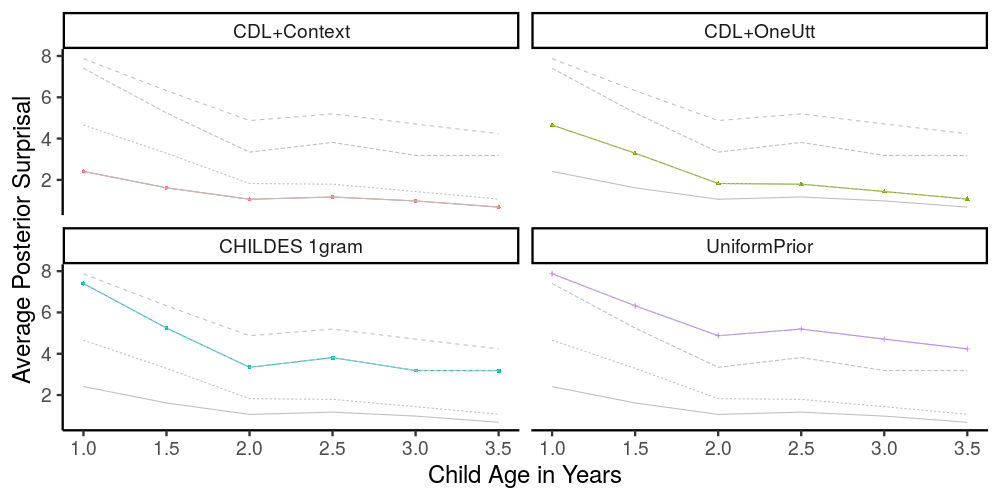

In [20]:
%%R -w 1000 -h 500

overview_mean_surprisal_by_age <- filter_model_subset(mean_surprisal_by_age, overview_set)
    
overview_mean_surprisal_for_gray = do.call('rbind', lapply(unique(overview_mean_surprisal_by_age$model), function(model){ get_ref_df(model, overview_mean_surprisal_by_age)}))

ggplot(overview_mean_surprisal_by_age) + geom_point(aes(x=age, y=posterior_surprisal_mean, color=model,
    shape = model)) + geom_line(aes(x=age, y=posterior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=posterior_surprisal_mean - .5*posterior_surprisal_sem, 
    ymax=posterior_surprisal_mean + .5*posterior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Years') +
    facet_wrap(~model) + geom_line(data=overview_mean_surprisal_for_gray, aes(x=age,y=posterior_surprisal_mean, linetype = line_model),colour='gray', alpha=1) +
    theme(legend.position='none')


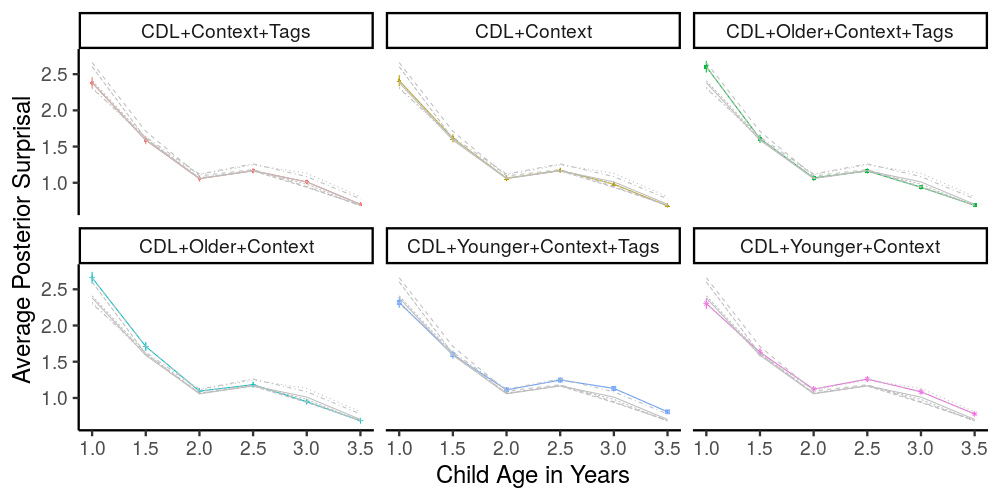

In [21]:
%%R -w 1000 -h 500

subset_mean_surprisal_by_age <- filter_model_subset(mean_surprisal_by_age, splits_tags_set)
    
subset_mean_surprisal_for_gray = do.call('rbind', lapply(unique(subset_mean_surprisal_by_age$model), function(model){ get_ref_df(model, subset_mean_surprisal_by_age)}))

ggplot(subset_mean_surprisal_by_age) + geom_point(aes(x=age, y=posterior_surprisal_mean, color=model,
    shape = model)) + geom_line(aes(x=age, y=posterior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=posterior_surprisal_mean - .5*posterior_surprisal_sem, 
    ymax=posterior_surprisal_mean + .5*posterior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Years') +
    facet_wrap(~model) + geom_line(data=subset_mean_surprisal_for_gray, aes(x=age,y=posterior_surprisal_mean, linetype = line_model),colour='gray', alpha=1) +
    theme(legend.position='none')


# Prior surprisal

In [22]:

%R mean_surprisal_by_age = aggregate(prior_probability ~ age + model, successes_across_time ,\
                function(x){mean(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age) = c('age','model','prior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(prior_probability ~ age + model, \
        successes_across_time, function(x){sem(-1 * log(x, base = 2))})
%R names(mean_surprisal_by_age_sem) = c('age','model','prior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 


,age,model,prior_surprisal_mean,prior_surprisal_sem
1,1.5,BERT+Context,5.444060,0.177099
2,1.5,BERT+OneUtt,9.366310,0.192144
3,1.5,CDL+Context,3.378815,0.150465
4,1.5,CDL+Context+Tags,3.268499,0.147755
5,1.5,CDL+Older+Context,3.489384,0.153283
...,...,...,...,...
92,3.0,CDL+Younger+Context+Tags,4.078283,0.122956
93,3.0,CDL+Younger+OneUtt,5.389112,0.124085
94,3.0,CDL+Younger+OneUtt+Tags,5.303635,0.120759
95,3.0,CHILDES 1gram,8.450722,0.086978


### Prior Surprisal Across Ages

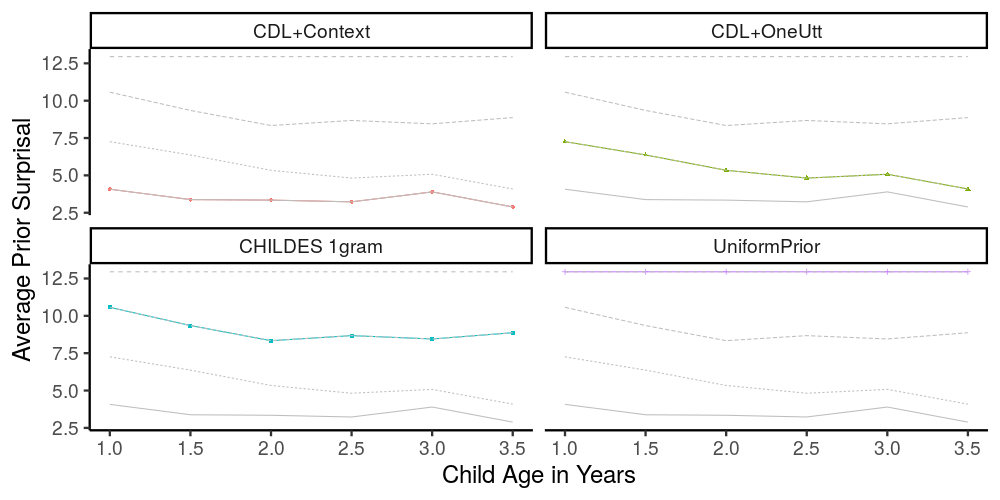

In [23]:
%%R -w 1000 -h 500

overview_mean_surprisal_by_age <- filter_model_subset(mean_surprisal_by_age, overview_set)
    
overview_mean_surprisal_for_gray = do.call('rbind', lapply(unique(overview_mean_surprisal_by_age$model), function(model){ get_ref_df(model, overview_mean_surprisal_by_age)}))

ggplot(overview_mean_surprisal_by_age) + geom_point(aes(x=age, y=prior_surprisal_mean, color=model,
    shape = model)) + geom_line(aes(x=age, y=prior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=prior_surprisal_mean - .5*prior_surprisal_sem, 
    ymax=prior_surprisal_mean + .5*prior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Prior Surprisal') + xlab('Child Age in Years') +
    facet_wrap(~model) + geom_line(data=overview_mean_surprisal_for_gray, aes(x=age,y=prior_surprisal_mean, linetype = line_model),colour='gray', alpha=1) +
    theme(legend.position='none')

# # Best performing CDL Context all/all, CHILDES 1gram and Uniform Prior 


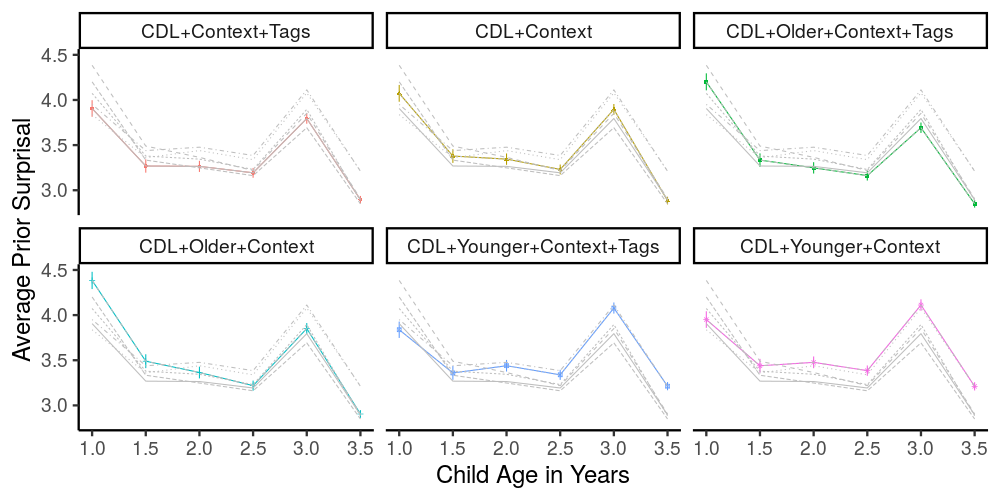

In [24]:
%%R -w 1000 -h 500

subset_mean_surprisal_by_age <- filter_model_subset(mean_surprisal_by_age, splits_tags_set)
    
subset_mean_surprisal_for_gray = do.call('rbind', lapply(unique(subset_mean_surprisal_by_age$model), function(model){ get_ref_df(model, subset_mean_surprisal_by_age)}))

ggplot(subset_mean_surprisal_by_age) + geom_point(aes(x=age, y=prior_surprisal_mean, color=model,
    shape = model)) + geom_line(aes(x=age, y=prior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=prior_surprisal_mean - .5*prior_surprisal_sem, 
    ymax=prior_surprisal_mean + .5*prior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Prior Surprisal') + xlab('Child Age in Years') +
    facet_wrap(~model) + geom_line(data=subset_mean_surprisal_for_gray, aes(x=age,y=prior_surprisal_mean, linetype = line_model),colour='gray', alpha=1) +
    theme(legend.position='none')


In [25]:
scores_across_time_short.set.value_counts()

success    117120
failure     41360
Name: set, dtype: int64

### Posterior Entropy Stratified by Successes vs. Failures

In [26]:
%R posterior_entropy_by_age = aggregate(posterior_entropy ~ age + model + set, scores_across_time_short ,\
                function(x){mean(x)})
%R names(posterior_entropy_by_age) = c('age','model', 'set', 'posterior_entropy_mean')
%R posterior_entropy_by_age_sem = aggregate(posterior_entropy ~ age + model + set, \
        scores_across_time_short, sem)
%R names(posterior_entropy_by_age_sem) = c('age','model','set','posterior_entropy_sem')
%R posterior_entropy_by_age = merge(posterior_entropy_by_age, posterior_entropy_by_age_sem) 
%R posterior_entropy_by_age

,age,model,set,posterior_entropy_mean,posterior_entropy_sem
1,1.5,BERT+Context,failure,2.620283,0.053280
2,1.5,BERT+Context,success,1.163872,0.043478
3,1.5,BERT+OneUtt,failure,2.693626,0.054083
4,1.5,BERT+OneUtt,success,1.752431,0.045915
5,1.5,CDL+Context,failure,2.334011,0.055511
...,...,...,...,...,...
188,3.0,CDL+Younger+OneUtt+Tags,success,1.066827,0.031014
189,3.0,CHILDES 1gram,failure,2.746001,0.044197
190,3.0,CHILDES 1gram,success,1.987798,0.031814
191,3.0,UniformPrior,failure,4.485359,0.045361


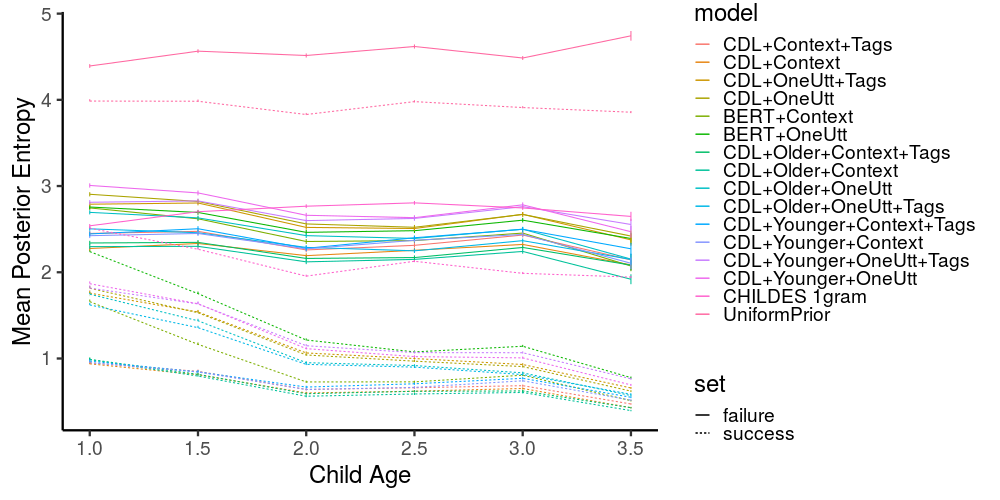

In [27]:
%%R -w 1000 -h 500
ggplot(posterior_entropy_by_age) + geom_line(aes(x=age, y=posterior_entropy_mean, color=model, linetype=set)
) + geom_errorbar(aes(x=age, ymin=posterior_entropy_mean - .5*posterior_entropy_sem, 
ymax=posterior_entropy_mean + .5*posterior_entropy_sem, color=model, linetype=set ), width=0) + theme_classic(
base_size=24) + ylab('Mean Posterior Entropy') + xlab('Child Age')

# 11 Information Gain 

In [28]:
%%R
# adjust the base from log to 2 in successes_across_time
successes_across_time$kl_flat_to_prior = -1 * log (exp(-1 * 
    successes_across_time$kl_flat_to_prior), base=2)
successes_across_time$kl_flat_to_posterior = -1 * log (exp(-1 * 
    successes_across_time$kl_flat_to_posterior), base=2)

In [29]:
%%R
mean_kl_flat_to_prior_by_age = aggregate(kl_flat_to_prior ~ age + model, successes_across_time, mean)
names(mean_kl_flat_to_prior_by_age) = c('age','model','kl_flat_to_prior')
mean_kl_flat_to_prior_by_age_sem = aggregate(kl_flat_to_prior ~ age + model,
        successes_across_time, sem)
names(mean_kl_flat_to_prior_by_age_sem) = c('age','model','kl_flat_to_prior_sem')
mean_kl_flat_to_prior_by_age = merge(mean_kl_flat_to_prior_by_age, mean_kl_flat_to_prior_by_age_sem) 


mean_kl_flat_to_posterior_by_age = aggregate(kl_flat_to_posterior ~ age + model, successes_across_time, mean)
names(mean_kl_flat_to_posterior_by_age) = c('age','model','kl_flat_to_posterior')
mean_kl_flat_to_posterior_by_age_sem = aggregate(kl_flat_to_posterior ~ age + model, 
        successes_across_time, sem)
names(mean_kl_flat_to_posterior_by_age_sem) = c('age','model','kl_flat_to_posterior_sem')
mean_kl_flat_to_posterior_by_age = merge(mean_kl_flat_to_posterior_by_age, 
    mean_kl_flat_to_posterior_by_age_sem) 

names(mean_kl_flat_to_posterior_by_age) = c('age','model','gain','gain_sem' )
mean_kl_flat_to_posterior_by_age$comparison = 'posterior'

names(mean_kl_flat_to_prior_by_age) = c('age','model','gain','gain_sem' )
mean_kl_flat_to_prior_by_age$comparison =  'fitted prior'

kls = rbind.fill(mean_kl_flat_to_posterior_by_age, mean_kl_flat_to_prior_by_age)
kls$age_in_months = kls$age * 12
head(kls)

  age                  model     gain  gain_sem comparison age_in_months
1 1.5           BERT+Context 20.18228 0.2291313  posterior            18
2 1.5            BERT+OneUtt 17.38759 0.1959852  posterior            18
3 1.5            CDL+Context 22.67835 0.2195226  posterior            18
4 1.5       CDL+Context+Tags 22.17011 0.2143087  posterior            18
5 1.5      CDL+Older+Context 23.54091 0.2288175  posterior            18
6 1.5 CDL+Older+Context+Tags 23.08966 0.2215326  posterior            18


In [30]:
%%R
subset(kls, comparison =='posterior' & model == 'UniformPrior')

   age        model      gain   gain_sem comparison age_in_months
16 1.5 UniformPrior  9.718705 0.06164715  posterior            18
32 1.0 UniformPrior  9.439147 0.06113035  posterior            12
48 2.5 UniformPrior  9.944039 0.04494087  posterior            30
64 2.0 UniformPrior  9.997663 0.05012110  posterior            24
80 3.5 UniformPrior  9.998799 0.04235069  posterior            42
96 3.0 UniformPrior 10.018282 0.04779062  posterior            36


In [31]:
%%R
# how to get the unigrams on every line
unigram_posterior = subset(kls, comparison =='posterior' & model == 'UniformPrior')
unigram_posterior['comparison'] = 'perceptual data'

excluding_unigram = subset(kls, model != 'UniformPrior')
by_model = split(excluding_unigram, as.character(excluding_unigram$model))
kls_with_uniform_prior = do.call('rbind', lapply(by_model, function(one_model){
        # merge by age in months
        unigram_posterior['model'] = one_model$model[1]
        return(rbind(one_model, unigram_posterior))    
})) 

In [32]:
%%R
kls_with_uniform_prior$comparison[kls_with_uniform_prior$
    comparison == 'fitted prior'] = "context (fitted prior)"

kls_with_uniform_prior$comparison[kls_with_uniform_prior$
    comparison == 'posterior'] = "perceptual data & context\n(posterior)"

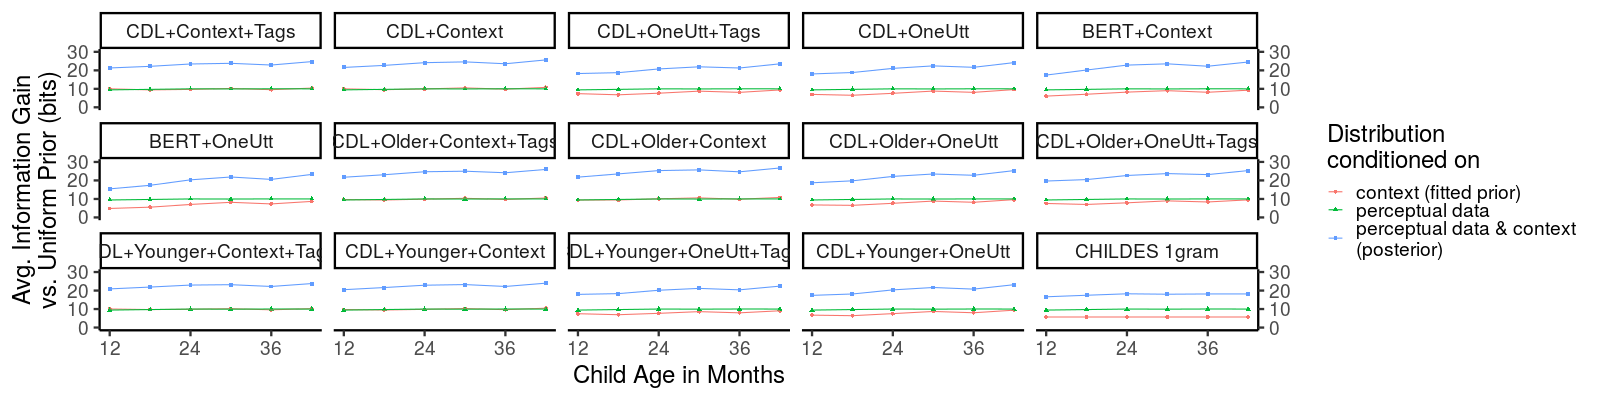

In [33]:
%%R -w 1600 -h 400
child_age_ticks = c(12,24,36,48) 
p1 = ggplot(subset(kls_with_uniform_prior, age_in_months > 6)) + geom_point(aes(x=age_in_months, 
y= gain, color=comparison,  shape=comparison)
) + facet_wrap(~model, ncol=5) + geom_line(aes(x=age_in_months, y= gain, color=comparison, 
shape=comparison)) + theme_classic(base_size=24) + coord_cartesian(ylim = c(0,30)
) + xlab('Child Age in Months') + ylab('Avg. Information Gain\nvs. Uniform Prior (bits)'
) + scale_y_continuous(sec.axis = sec_axis( trans=~.)
) + scale_color_discrete(name = "Distribution\nconditioned on") + scale_shape_discrete(
name = "Distribution\nconditioned on") + scale_x_continuous( breaks = child_age_ticks, 
labels = child_age_ticks)
ggsave('figures/information_gain_2.pdf', width=16, height=4)
print(p1)

# 12 Posterior Probability as a function of edit distance

In [34]:
%%R
surprisal_by_edit_distance = aggregate(posterior_probability ~ edit_distance + model, successes_across_time, 
    function(x){mean(-1 * log(x, base = 2))})
names(surprisal_by_edit_distance) = c('edit_distance', 'model', 'mean_posterior_surprisal')
sem <- function(x) sd(x)/sqrt(length(x))
surprisal_by_edit_distance_sem = aggregate(posterior_probability ~ edit_distance + model, successes_across_time, 
    function(x){sem(-1 * log(x, base = 2))})
names(surprisal_by_edit_distance_sem) = c('edit_distance','model','mean_posterior_surprisal_sem')
surprisal_by_edit_distance = merge(surprisal_by_edit_distance, surprisal_by_edit_distance_sem)
surprisal_by_edit_distance$high = surprisal_by_edit_distance$mean_posterior_surprisal 
    + 1/2 * surprisal_by_edit_distance$mean_posterior_surprisal_sem
surprisal_by_edit_distance$low = surprisal_by_edit_distance$mean_posterior_surprisal 
    - 1/2 * surprisal_by_edit_distance$mean_posterior_surprisal_sem
test = subset(surprisal_by_edit_distance, edit_distance ==1 )
test$prob = exp(-1*test$mean_posterior_surprisal)


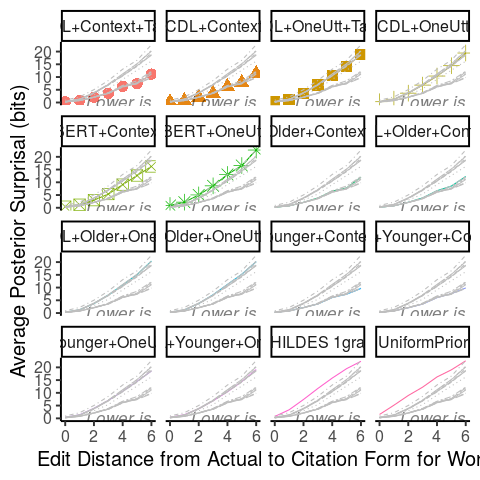

In [35]:
%%R

surprisal_by_edit_distance_for_plot = subset(surprisal_by_edit_distance, edit_distance <= 6)

surprisal_for_gray = do.call('rbind', lapply(unique(surprisal_by_edit_distance_for_plot$model), function(model){ get_ref_df(model, surprisal_by_edit_distance_for_plot)}))

p1= ggplot(surprisal_by_edit_distance_for_plot) + geom_point(aes(x=edit_distance, 
    y = mean_posterior_surprisal, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab('Average Posterior Surprisal (bits)') + 
    geom_errorbar(aes(x=edit_distance, ymin=low, ymax= high, color=model), width = 0) + 
    geom_line(aes(x=edit_distance, y = mean_posterior_surprisal, color = model, 
shape=model)) + theme(legend.position=c(.3, .8), legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Lower is better", 
    x=5.5, y=.05, alpha=.5, size=6, fontface ="italic") +
facet_wrap(~model) + geom_line(data=surprisal_for_gray, aes(x=edit_distance,y=mean_posterior_surprisal, linetype = line_model),colour='gray', alpha=1)+
theme(legend.position='none')

ggsave('figures/multiplier_by_edit_distance.pdf', height=6, width=8)    
print(p1)

In [36]:
%%R
# Multiplier for each 
unigram_prior = subset(surprisal_by_edit_distance, model == "UniformPrior")[,c('edit_distance',
    'mean_posterior_surprisal')]
names(unigram_prior)[2] = "unigram_prior_prob"

surprisal_by_edit_distance = merge(surprisal_by_edit_distance, unigram_prior)
surprisal_by_edit_distance$multiplier = 2^( surprisal_by_edit_distance$unigram_prior_prob -
    surprisal_by_edit_distance$mean_posterior_surprisal)

head(surprisal_by_edit_distance, n=10)


   edit_distance                  model mean_posterior_surprisal
1              0           BERT+Context                0.4359863
2              0            BERT+OneUtt                0.9188391
3              0            CDL+Context                0.2449324
4              0       CDL+Context+Tags                0.2478087
5              0      CDL+Older+Context                0.2201584
6              0 CDL+Older+Context+Tags                0.2162775
7              0       CDL+Older+OneUtt                0.2859285
8              0  CDL+Older+OneUtt+Tags                0.2679335
9              0             CDL+OneUtt                0.3241827
10             0        CDL+OneUtt+Tags                0.3113139
   mean_posterior_surprisal_sem      high       low unigram_prior_prob
1                    0.02328505 0.4359863 0.4359863           1.527192
2                    0.03232264 0.9188391 0.9188391           1.527192
3                    0.01590334 0.2449324 0.2449324           1.527192
4

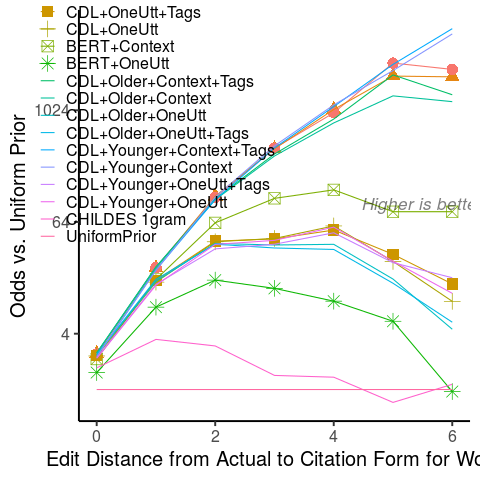

In [37]:
%%R

# Added: no subsetting for the odds uniform prior

p2= ggplot(subset(surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab(
    'Odds vs. Uniform Prior') + geom_line(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model))+ theme(legend.position=c(.2, .8), 
    legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Higher is better", 
    x=5.5, y=100, alpha=.5, size=6, fontface ="italic") + scale_y_continuous(trans='log2')
ggsave('figures/multiplier_by_edit_dstance_log_scale_all.pdf', height=6, width=8)    
print(p2)

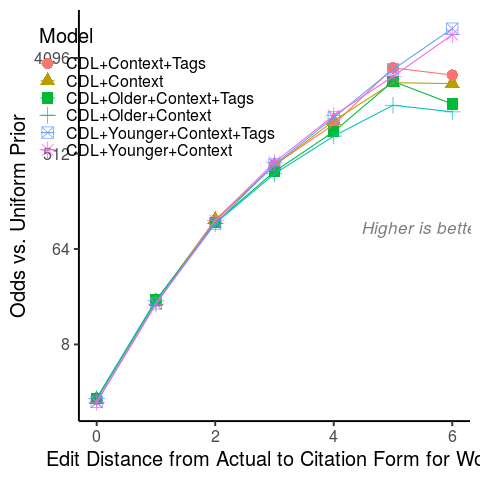

In [38]:
%%R

subset_surprisal_by_edit_distance <- filter_model_subset(surprisal_by_edit_distance, splits_tags_set)

p2= ggplot(subset(subset_surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab(
    'Odds vs. Uniform Prior') + geom_line(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model))+ theme(legend.position=c(.2, .8), 
    legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Higher is better", 
    x=5.5, y=100, alpha=.5, size=6, fontface ="italic") + scale_y_continuous(trans='log2')
ggsave('figures/multiplier_by_edit_dstance_log_scale_subset.pdf', height=6, width=8)    
print(p2)

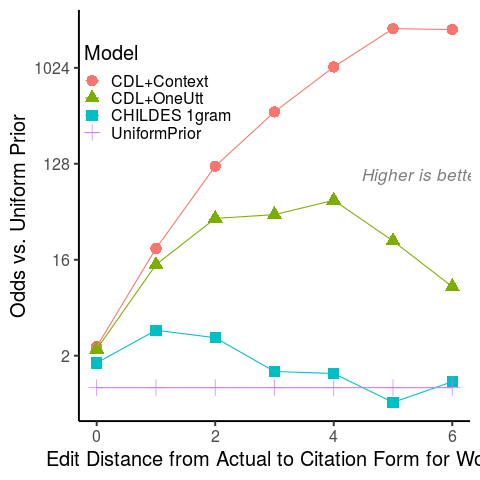

In [39]:
%%R

overview_surprisal_by_edit_distance <- filter_model_subset(surprisal_by_edit_distance, overview_set)

p2= ggplot(subset(overview_surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab(
    'Odds vs. Uniform Prior') + geom_line(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model))+ theme(legend.position=c(.2, .8), 
    legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Higher is better", 
    x=5.5, y=100, alpha=.5, size=6, fontface ="italic") + scale_y_continuous(trans='log2')
ggsave('figures/multiplier_by_edit_dstance_log_scale_overview.pdf', height=6, width=8)    
print(p2)

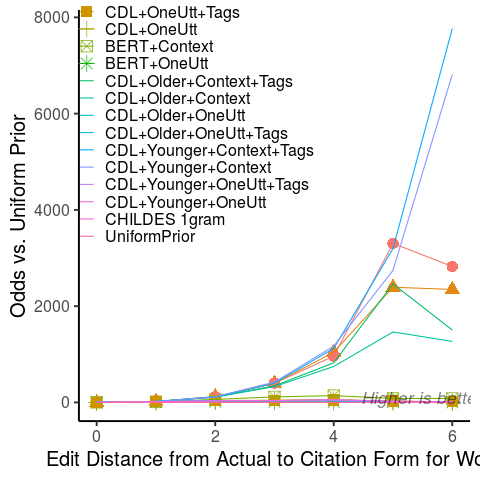

In [40]:
%%R
p2= ggplot(subset(surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab(
    'Odds vs. Uniform Prior') + geom_line(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model))+ theme(legend.position=c(.3, .8), 
    legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Higher is better", 
    x=5.5, y=100, alpha=.5, size=6, fontface ="italic")
ggsave('figures/multiplier_by_edit_dstance_linear_scale.pdf', height=6, width=8)    
print(p2)

# 13 ROC for Completions 

In [41]:
%%R
library(plotROC)

In [42]:
%%R 
scores_across_time_short$set_binarized = 0
scores_across_time_short$set_binarized[scores_across_time_short$set == 'failure'] = 1
table(scores_across_time_short$set_binarized)

[1] 117120  41360


In [43]:
%%R
# Get AUC scores into these
unique(as.character(scores_across_time_short$model))

 [1] "BERT+OneUtt"              "BERT+Context"            
 [3] "CDL+OneUtt+Tags"          "CDL+Context+Tags"        
 [5] "CDL+OneUtt"               "CDL+Context"             
 [7] "CDL+Younger+OneUtt+Tags"  "CDL+Younger+Context+Tags"
 [9] "CDL+Younger+OneUtt"       "CDL+Younger+Context"     
[11] "CDL+Older+OneUtt+Tags"    "CDL+Older+Context+Tags"  
[13] "CDL+Older+OneUtt"         "CDL+Older+Context"       
[15] "UniformPrior"             "CHILDES 1gram"           


In [44]:
%%R
library('pROC')
auc_by_model = do.call('rbind', lapply(unique(scores_across_time_short$model), 
      function(model_name){
    one_model = subset(scores_across_time_short, model == model_name)
    roc1 = roc(one_model$set_binarized, one_model$posterior_entropy)
    return(data.frame(model=model_name, auc = auc(roc1)))}))

scores_across_time_short = merge(scores_across_time_short, auc_by_model)


R[write to console]: Type 'citation("pROC")' for a citation.

R[write to console]: 
Attaching package: ‘pROC’


R[write to console]: The following object is masked from ‘package:plotROC’:

    ggroc


R[write to console]: The following objects are masked from ‘package:stats’:

    cov, smooth, var


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls 

In [45]:
%%R
scores_across_time_short$model_with_auc = paste0(scores_across_time_short$model,' (AUC = ',
round(scores_across_time_short$auc, 3),')')

In [46]:
%%R
scores_across_time_short$model_with_auc[1:10]

 [1] "BERT+Context (AUC = 0.848)" "BERT+Context (AUC = 0.848)"
 [3] "BERT+Context (AUC = 0.848)" "BERT+Context (AUC = 0.848)"
 [5] "BERT+Context (AUC = 0.848)" "BERT+Context (AUC = 0.848)"
 [7] "BERT+Context (AUC = 0.848)" "BERT+Context (AUC = 0.848)"
 [9] "BERT+Context (AUC = 0.848)" "BERT+Context (AUC = 0.848)"


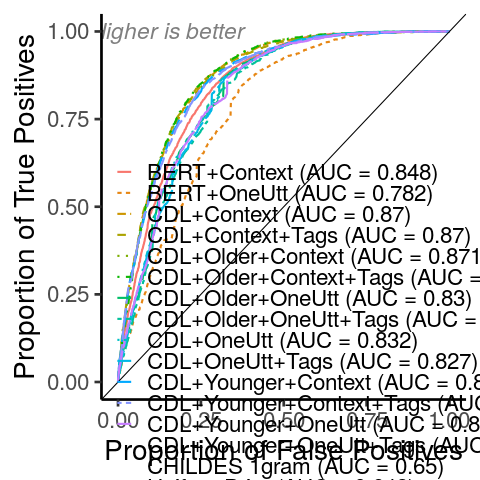

In [47]:
%%R 
p1 = ggplot(scores_across_time_short[,c('set_binarized', 'model_with_auc', 'posterior_entropy')], 
       aes(d=set_binarized, m=posterior_entropy, color=model_with_auc, linetype = model_with_auc)
) + theme_classic(base_size=28)+ geom_roc(n.cuts=0) + xlab('Proportion of False Positives'
) + ylab('Proportion of True Positives') + theme(legend.position=c(.67, .20),
legend.background = element_blank(), legend.title = element_blank()) + annotate("text",
label= "Higher is better", size=8, fontface="italic", x=.15, y=1, alpha =.5) + geom_abline(intercept=0, slope=1)
print(p1)
ggsave('figures/roc_2.pdf', height=12, width=12)    